# Cargar el dataset Preprocesado

In [3]:
%pip install -q pandas
import pandas as pd

# Cargar el dataset desde la carpeta Data
processed_data = pd.read_csv('Data/youtoxic_english_1000_processed.csv')
processed_data.head()


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


,aaannnyything,ability,able,absolutely,absolutely nothing,abuse,according,accountable,accountable actions,accounts,...,youre,youth,youtube,youve,zimmerman,zimmerman case,zimmerman michael,zimmermans,zionist,IsToxic
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.089395,0.093338,0.0,...,0.067337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4,0.0,0.0,0.0,0.185577,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


# Preparar para el modelo de Machine Learning
Dividir el dataframe en 'features' y 'labels'.
Hacer subdivisiones en conjuntos de prueba y de entrenamiento. Escalar o normalizar las características si es necesario.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separar la variable objetivo 'IsToxic' y nombrarla 'labels'
labels = processed_data['IsToxic']

# Eliminar la columna 'IsToxic' del dataframe y renombrar el dataframe como 'features'
features = processed_data.drop(columns=['IsToxic'])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Iniciar StandardScaler
scaler = StandardScaler()

# Aplicar scaler a los datos de entrenamiento y prueba
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Mostrar la forma de ambos sets
X_train_scaled.shape, X_test_scaled.shape

((800, 5000), (200, 5000))

# Primer modelo de ML
### Usando un algoritmo de Regresión Logística


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Classification Report:
              precision    recall  f1-score   support

       False       0.62      0.73      0.67        93
        True       0.73      0.62      0.67       107

    accuracy                           0.67       200
   macro avg       0.67      0.67      0.67       200
weighted avg       0.68      0.67      0.67       200



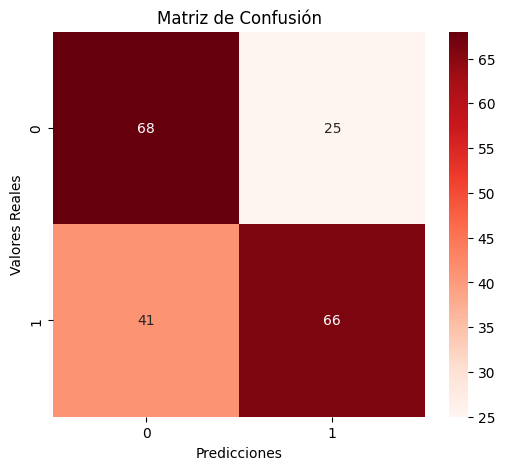


Accuracy en entrenamiento: 0.9962
Accuracy en test: 0.6700
Diferencia (overfitting): 0.3262


In [5]:
%pip install -q seaborn matplotlib

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Crear y entrenar el modelo de regresión logística
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)

# Imprimir métricas de rendimiento
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Crear y visualizar matriz de confusión
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Matriz de Confusión')
plt.ylabel('Valores Reales')
plt.xlabel('Predicciones')
plt.show()

# Calcular y mostrar accuracy en train y test
train_score = lr_model.score(X_train_scaled, y_train)
test_score = lr_model.score(X_test_scaled, y_test)

print(f"\nAccuracy en entrenamiento: {train_score:.4f}")
print(f"Accuracy en test: {test_score:.4f}")
print(f"Diferencia (overfitting): {abs(train_score - test_score):.4f}")